In [1]:
import pandas as pd
import networkx as nx
from pyvis.network import Network
import igraph as ig
import leidenalg as la
from pathlib import Path


In [2]:
CSV_PATH = Path("../Data/relationships_countries.csv")
df_raw = pd.read_csv(CSV_PATH)
print("Shape:", df_raw.shape)
df_raw.head(3)

Shape: (89, 4)


,sent_id,source,target,sentence
0,70,Austria,France,After a period of diplomatic and military esca...
1,70,France,Hungary,After a period of diplomatic and military esca...
2,70,Austria,Hungary,After a period of diplomatic and military esca...


In [3]:
df_raw.columns

Index(['sent_id', 'source', 'target', 'sentence'], dtype='object')

In [5]:
df = df_raw.copy()

# Add a weight column
df["weight"] = 1

# Remove self-loops
df = df[df["source"].str.lower() != df["target"].str.lower()].copy()

# Remove duplicates
df["pair"] = df.apply(lambda r: tuple(sorted([r["source"], r["target"]])), axis=1)
df = df.groupby("pair", as_index=False)["weight"].sum()
df[["source", "target"]] = pd.DataFrame(df["pair"].tolist(), index=df.index)
df = df.drop(columns=["pair"])

# Check
print("Nodes:", len(set(df["source"]) | set(df["target"])))
print("Edges:", len(df))
df.head(10)

Nodes: 46
Edges: 74


,weight,source,target
0,1,Albania,Bulgaria
1,1,Albania,Greece
2,1,Albania,Hungary
3,1,Albania,Poland
4,1,Albania,Romania
5,1,Algeria,Morocco
6,1,Australia,Canada
7,1,Australia,Philippines
8,1,Austria,France
9,1,Austria,Germany


In [6]:
# Save the cleaned dataset
output_path = "../Data/relationships_clean_1.7.csv"
df.to_csv(output_path, index=False, encoding="utf-8")

In [7]:
import networkx as nx

# Create an undirected graph object
G = nx.Graph()

# Add edges from your cleaned dataframe
G.add_weighted_edges_from(df[["source", "target", "weight"]].itertuples(index=False, name=None))

# Basic info about the graph
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

Nodes: 46
Edges: 74


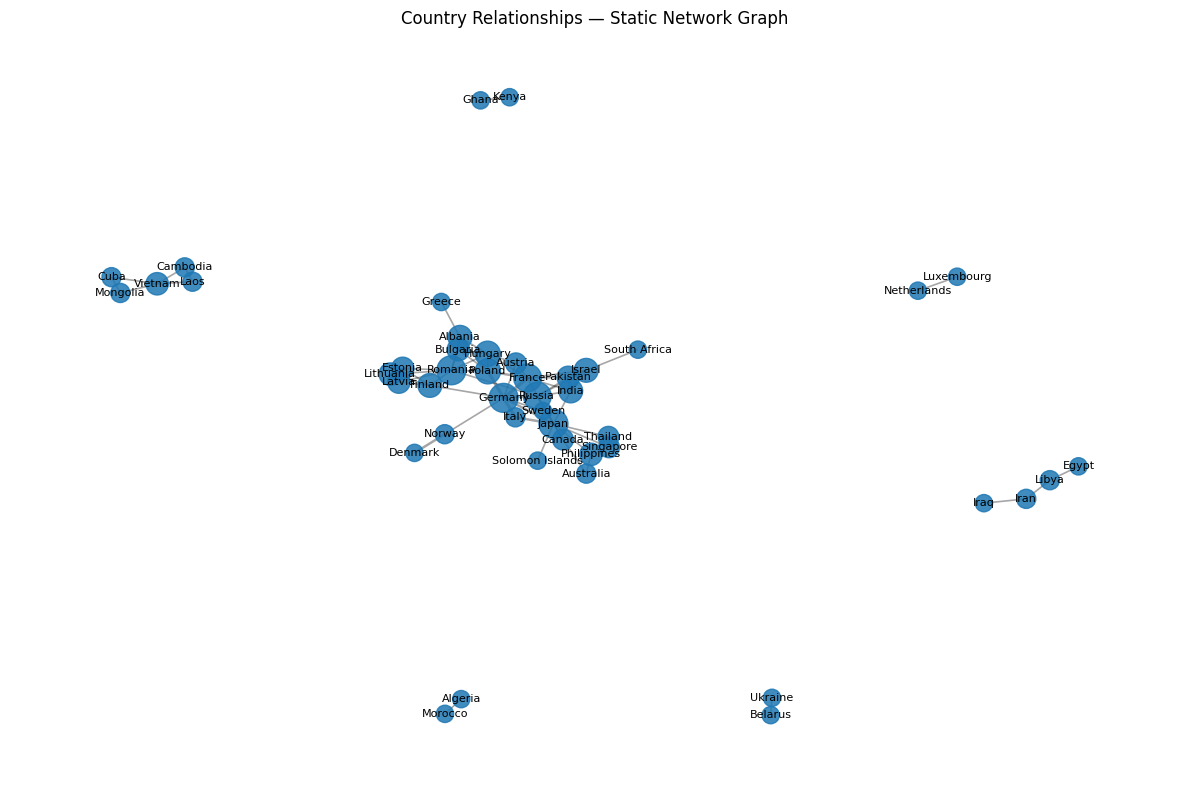

In [8]:
import matplotlib.pyplot as plt

# Node size proportional to degree 
deg = dict(G.degree())
node_sizes = [120 + 35 * deg[n] for n in G.nodes()]

# Edge width proportional to weight
edge_widths = [0.6 + 0.6 * G[u][v].get("weight", 1) for u, v in G.edges()]

# Layout defines how nodes are placed
pos = nx.spring_layout(G, seed=42)

# Plot
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.85)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.35)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Country Relationships — Static Network Graph")
plt.axis("off")
plt.tight_layout()
plt.show()

In [9]:
from pyvis.network import Network
import networkx as nx

net = Network(height="750px", width="100%", notebook=True,
              bgcolor="#ffffff", cdn_resources="in_line")  
net.barnes_hut()

deg = dict(G.degree())
for n in G.nodes():
    title = f"{n} - degree: {deg[n]}"
    net.add_node(n, title=title, value=deg[n])

for u, v, data in G.edges(data=True):
    w = data.get("weight", 1)
    net.add_edge(u, v, value=w, title=f"Weight: {w}")

html_path = Path("../Docs/network_pyvis_1.7.html")

html_path.parent.mkdir(parents=True, exist_ok=True) 

html_str = net.generate_html()
with open(html_path, "w", encoding="utf-8") as f:
    f.write(html_str)

print(f"Saved: {html_path}")

Saved: ..\Docs\network_pyvis_1.7.html


In [10]:
from cdlib import algorithms
from pyvis.network import Network
import networkx as nx
from pathlib import Path

coms = algorithms.leiden(G)
new_com = coms.to_node_community_map()
dict_com = {k: v[0] for k, v in new_com.items()}

nx.set_node_attributes(G, dict_com, "group")

com_net = Network(notebook=True, width="1300px", height="700px",
                  bgcolor="#222222", font_color="white", cdn_resources="in_line")
com_net.from_nx(G)
com_net.show_buttons(filter_=["physics"])
com_net.repulsion()

out_path = Path("../Docs/network_pyvis_leiden.html")
out_path.parent.mkdir(parents=True, exist_ok=True)
html_str = com_net.generate_html()
with open(out_path, "w", encoding="utf-8") as f:
    f.write(html_str)

print(f"Saved: {out_path}")

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'wurlitzer', 'infomap', 'bayanpy'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}
Saved: ..\Docs\network_pyvis_leiden.html


In [11]:
import networkx as nx
from collections import defaultdict

deg_c = dict(G.degree())
close_c = nx.closeness_centrality(G)
between_c = nx.betweenness_centrality(G, normalized=True)

communities = defaultdict(list)
for n, cid in dict_com.items():
    communities[cid].append(n)

num_com = len(communities)
sizes = {cid: len(nodes) for cid, nodes in communities.items()}
largest_id = max(sizes, key=sizes.get)
largest_size = sizes[largest_id]

bridge_edges = [(u, v) for u, v in G.edges() if dict_com.get(u) != dict_com.get(v)]
bridge_ratio = len(bridge_edges) / G.number_of_edges() if G.number_of_edges() else 0.0

top_deg = sorted(deg_c.items(), key=lambda x: x[1], reverse=True)[:5]
top_betw = sorted(between_c.items(), key=lambda x: x[1], reverse=True)[:5]

Q = None
try:
    from networkx.algorithms.community.quality import modularity
    community_sets = [set(nodes) for nodes in communities.values()]
  
    Q = modularity(G, community_sets, weight="weight")
except Exception:
    pass

print("Communities:", num_com, "| Largest:", largest_id, "size:", largest_size)
print("Bridge edges:", len(bridge_edges), f"({bridge_ratio:.1%} of all edges)")
print("Top degree:", top_deg)
print("Top betweenness:", top_betw)
print("Modularity Q:", None if Q is None else round(Q, 3))

Communities: 10 | Largest: 0 size: 10
Bridge edges: 14 (18.9% of all edges)
Top degree: [('Romania', 9), ('Germany', 9), ('Japan', 9), ('France', 8), ('Russia', 8)]
Top betweenness: [('Germany', 0.13941077441077437), ('Japan', 0.11159932659932659), ('Russia', 0.09791245791245788), ('Romania', 0.07848484848484848), ('France', 0.03757575757575758)]
Modularity Q: 0.609


In [12]:
import networkx as nx
from cdlib import algorithms
from pyvis.network import Network
from pathlib import Path

# Leiden communities 
coms = algorithms.leiden(G)
new_com = coms.to_node_community_map()
dict_com = {node: cid_list[0] for node, cid_list in new_com.items()}
dict_com = {n: dict_com.get(n, 0) for n in G.nodes()} 
nx.set_node_attributes(G, dict_com, "group")

deg_c = dict(G.degree())
close_c = nx.closeness_centrality(G)
between_c = nx.betweenness_centrality(G, normalized=True)

# Create PyVis network
net = Network(notebook=True, width="1300px", height="700px",
              bgcolor="#ffffff", font_color="black", cdn_resources="in_line")
net.barnes_hut()

# Add nodes manually
for n in G.nodes():
    title = (
        f"<b>{n}</b><br>"
        f"Degree: {deg_c.get(n,0)}<br>"
        f"Closeness: {close_c.get(n,0):.4f}<br>"
        f"Betweenness: {between_c.get(n,0):.4f}<br>"
        f"Community: {dict_com.get(n,0)}"
    )
    net.add_node(
        n,
        label=str(n),
        title=title,
        value=float(deg_c.get(n, 1)),   # node size by degree
        group=dict_com.get(n, 0)        # color by community
    )

# Add edges
for u, v, data in G.edges(data=True):
    w = data.get("weight", 1)
    net.add_edge(u, v, value=w, title=f"Weight: {w}")

# Force labels to appear clearly
options_str = """
{
  "nodes": {
    "font": { "size": 18, "color": "#111111", "face": "arial" },
    "shape": "dot"
  },
  "interaction": { "hover": true }
}
"""
net.set_options(options_str)

# Save safely
out_path = Path("../Docs/network_pyvis_leiden_final.html")
out_path.parent.mkdir(parents=True, exist_ok=True)
html = net.generate_html()
with open(out_path, "w", encoding="utf-8") as f:
    f.write(html)

print(f"Saved: {out_path.resolve()}")

Saved: D:\Data_Projects\20th_century_project\Docs\network_pyvis_leiden_final.html


The Leiden algorithm detected 10 communities in total.
The largest community includes Germany, Japan, Russia, France, and Romania — countries that played central roles in major geopolitical events of the 20th century, especially during the two World Wars and the Cold War.
Their strong interconnections make historical sense, as these nations frequently interacted through conflicts, alliances, and diplomacy.

Another smaller community grouped Vietnam, Cambodia, Laos, China, and Mongolia, which also aligns with history — these countries shared close political and ideological ties during the Cold War era and were often mentioned together in the context of regional conflicts in Southeast Asia.

In [35]:
def plot_top_values(df, column_name, title, top_n=10):
    """
    Reusable barplot function for centrality metrics or any numerical column.
    """
    df_plot = df.sort_values(by=column_name, ascending=False).head(top_n)
    plt.figure(figsize=(10,5))
    sns.barplot(data=df_plot, x="Country", y=column_name, palette="crest")
    plt.title(title)
    plt.xlabel("Country")
    plt.ylabel(column_name)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

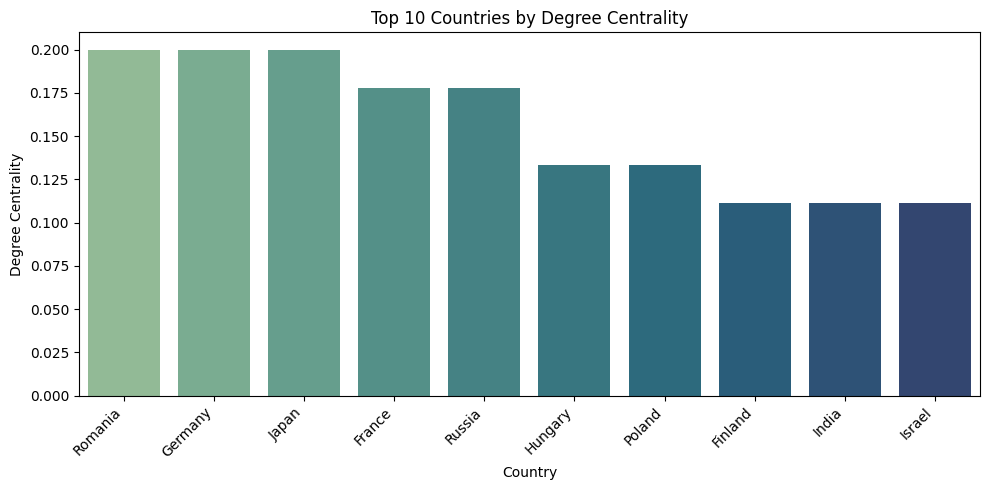

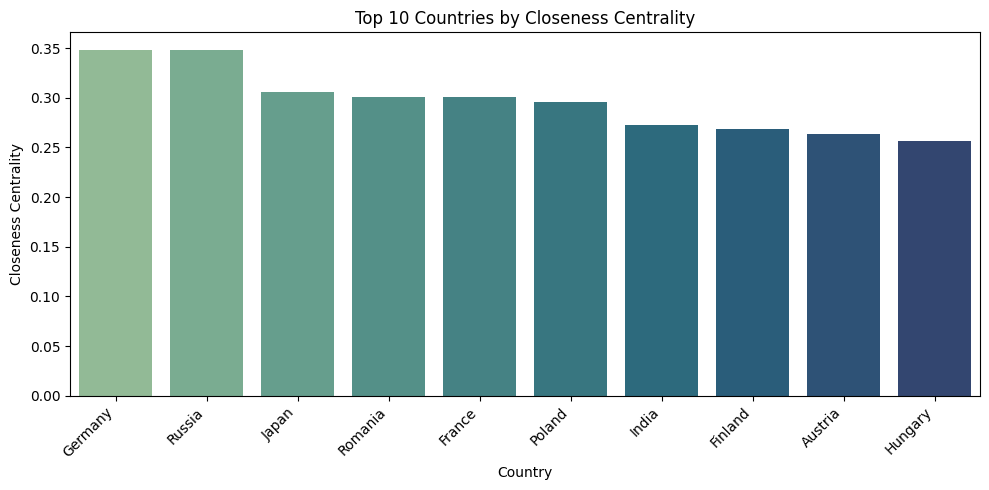

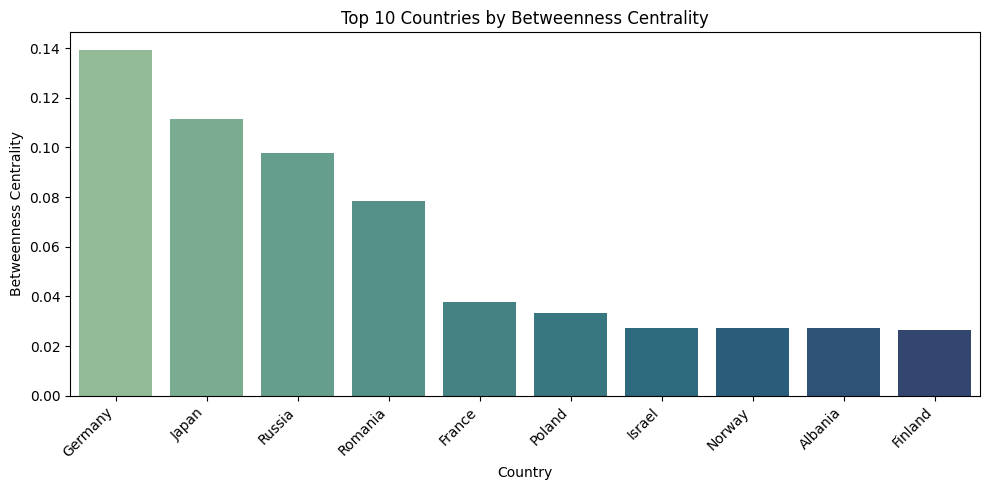

In [36]:
plot_top_values(df_centrality, "Degree Centrality", "Top 10 Countries by Degree Centrality")
plot_top_values(df_centrality, "Closeness Centrality", "Top 10 Countries by Closeness Centrality")
plot_top_values(df_centrality, "Betweenness Centrality", "Top 10 Countries by Betweenness Centrality")